In [1]:
%load_ext autoreload
%autoreload 2

In [136]:
import os
import glob
import re
import itertools
import time
import joblib
import random
import itertools

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
pd.options.display.max_colwidth = -1
pd.options.display.precision = 3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import container
from matplotlib.lines import Line2D

from sklearn import metrics
from sklearn.metrics import auc, roc_curve, make_scorer
from sklearn import svm, ensemble, datasets

In [3]:
import parsl
parsl.clear()

from polyfuse.configs.local import config
parsl.load(config)

#parsl.load()

from polyfuse import apps, transformations

In [4]:
out_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed'
training_fraction = 0.85

In [5]:
truth = apps.concatenate_true_fusions('/cephfs/users/annawoodard/fusion-simulation/data/processed/*', out_dir)

In [6]:
truth = pd.read_hdf(truth.result(), 'data')

In [7]:
callers = ['starseqr', 'starfusion', 'arriba', 'fusioncatcher', 'pizzly']
callers = ['starseqr', 'starfusion', 'arriba', 'fusioncatcher', 'pizzly', 'mapsplice2']

In [35]:
parsed_caller_data = apps.parse_caller_data(out_dir, callers)

In [36]:
caller_data_path = apps.concatenate_caller_data(out_dir, inputs=parsed_caller_data)
caller_data = pd.read_hdf(caller_data_path.result(), 'data')

In [37]:
samples = sorted(caller_data['sample'].unique())
#random.shuffle(samples)
training_samples = samples[:int(len(samples) * training_fraction)]
testing_samples = samples[int(len(samples) * training_fraction):]

In [38]:
start = time.time()
x_train, y_train = apps.assemble_data(training_samples, callers, out_dir)
print('assembled data in {:.1f}s'.format((time.time() - start)))

assembled data in 63.2s


fit models in 195.1s


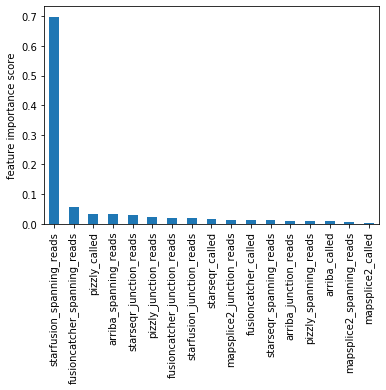

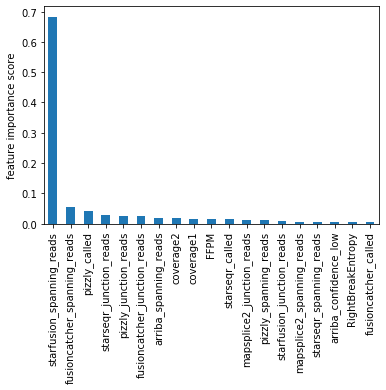

In [46]:
start = time.time()
os.makedirs(os.path.join(out_dir, 'models'), exist_ok=True)

base_columns = []
for c in callers:
    base_columns += [c + '_called', c + '_spanning_reads', c + '_junction_reads']
base_columns.remove('starfusion_called')
optimized_features = [
    'starseqr_called', 'starseqr_spanning_reads', 'starseqr_junction_reads',
    'starfusion_spanning_reads', 'starfusion_junction_reads', 'arriba_spanning_reads',
    'fusioncatcher_called', 'fusioncatcher_spanning_reads', 'fusioncatcher_junction_reads',
    'pizzly_called', 'pizzly_spanning_reads', 'pizzly_junction_reads', 'mapsplice2_spanning_reads',
    'mapsplice2_junction_reads', 'FFPM', 'RightBreakEntropy', 'coverage1', 'coverage2', 'arriba_confidence_low'
]
classifiers = []
for features in [
            base_columns,
            optimized_features
        ]:
    #label = 'LSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.LinearSVC(probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]


    #label = 'DefaultSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(probability=True)
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]

    #label = 'SVC{}Features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(C=10, gamma='auto', probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]
    
    #label = 'RFC{}F'.format(len(features))
    #trans = 'noop'
    #classifier = ensemble.RandomForestClassifier()
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]

    
    label = 'GBC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=1250, subsample=1.)
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(features, label, trans)]
    
    plt.figure()
    feature_importances = pd.Series(classifier.feature_importances_, features).sort_values(ascending=False)
    feature_importances.plot(kind='bar')
    plt.ylabel('feature importance score')

    label = 'DefaultGBC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier()
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(features, label, trans)]
    

print('fit models in {:.1f}s'.format((time.time() - start)))

In [47]:
x_train.shape, len(y_train), sum(y_train)

((34696, 30), 34696, 18500)

In [48]:
start = time.time()
model_data = pd.read_hdf(
    apps.predict(testing_samples, out_dir, classifiers, callers), 'data'
)
print('assembled predictions in {:.1f}s'.format((time.time() - start)))

assembled predictions in 94.4s


In [49]:
summary = apps.make_summary(out_dir, testing_samples)

In [54]:
summary = summary[summary['sample'] != 'LIB-04648wt']

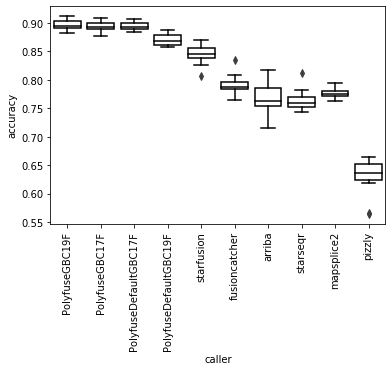

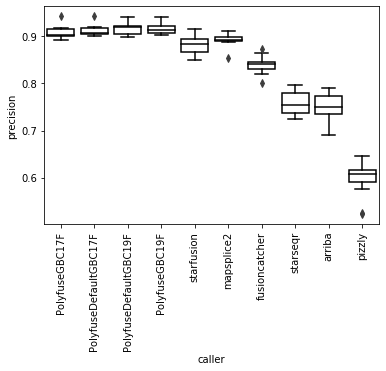

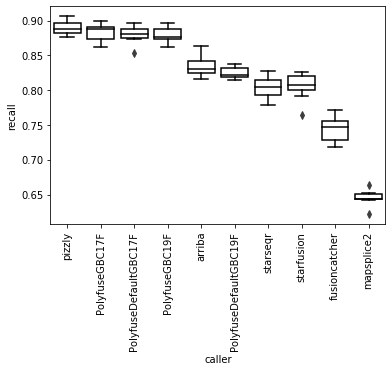

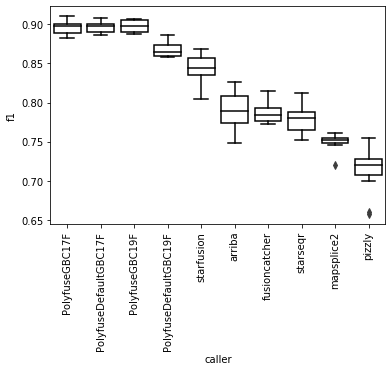

In [55]:
os.makedirs('plots', exist_ok=True)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.figure()
    ax = sns.boxplot(x="caller", y=metric, data=summary.sort_values(by=metric, ascending=False))
    labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    _ = plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
    _ = plt.setp(ax.lines, color='k')
    plt.savefig('plots/{}.pdf'.format(metric))

In [106]:
from matplotlib.lines import Line2D
Line2D.filled_markers

('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

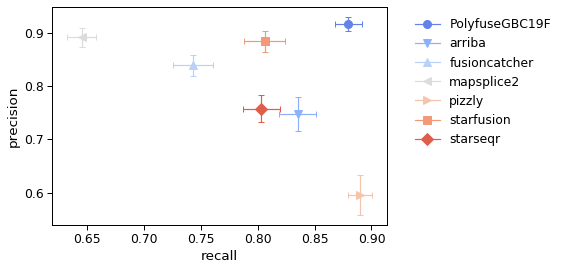

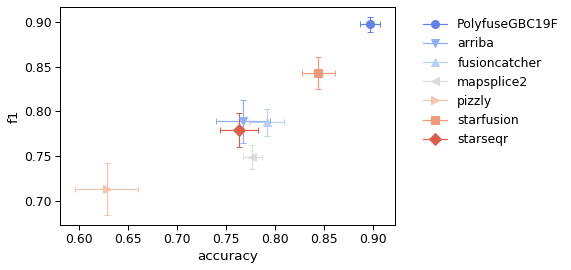

In [135]:
sns.set_palette(sns.color_palette("coolwarm", 7))
sns.diverging_palette(220, 20, n=7)
sns.diverging_palette(145, 280, s=85, l=25, n=7)
sns.set_context('paper', font_scale=1.4)
#markers = itertools.cycle(Line2D.filled_markers)
markers = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'D'))

top_model_summary = summary[~summary.caller.str.contains('PolyfuseDefaultGBC17F|PolyfuseDefaultGBC19F|PolyfuseGBC17F')]
means = top_model_summary.groupby('caller').mean()
stds = top_model_summary.groupby('caller').std()

for x, y in [('recall', 'precision'), ('accuracy', 'f1')]:

    fig, ax = plt.subplots()

    for caller in means.index:
        plt.errorbar(
            [means.loc[caller][x]],
            [means.loc[caller][y]],
            xerr=stds.loc[caller][x],
            yerr=stds.loc[caller][y],
            label=caller,
            marker=next(markers),
            markersize=8,
            capsize=3
        )
    plt.xlabel(x)
    plt.ylabel(y)
    handles, labels = ax.get_legend_handles_labels()
    handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]

    
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), frameon=False)


In [57]:
summary.groupby('caller').mean().sort_values(by='accuracy', ascending=False)

,tp,fp,fn,tn,recall,precision,accuracy,f1,mcc
caller,,,,,,,,,
PolyfuseGBC19F,439.857,40.143,60.143,432.429,0.880,0.917,0.897,0.898,0.794
PolyfuseDefaultGBC17F,439.714,41.714,60.286,430.857,0.879,0.914,0.895,0.896,0.790
PolyfuseGBC17F,441.429,44.286,58.571,428.286,0.883,0.909,0.894,0.896,0.788
PolyfuseDefaultGBC19F,412.571,38.000,87.429,434.571,0.825,0.916,0.871,0.868,0.746
starfusion,403.083,53.167,96.917,409.833,0.806,0.884,0.844,0.843,0.691
fusioncatcher,371.500,71.750,128.500,391.250,0.743,0.838,0.791,0.788,0.588
mapsplice2,322.714,39.571,177.286,433.000,0.645,0.891,0.777,0.749,0.580
arriba,417.500,141.500,82.500,321.500,0.835,0.748,0.767,0.789,0.534
starseqr,401.583,129.417,98.417,333.583,0.803,0.757,0.763,0.779,0.524


In [58]:
summary.sort_values(by='accuracy', ascending=False)

,sample,caller,tp,fp,fn,tn,recall,precision,accuracy,f1,mcc
15,LIB-04650wt,PolyfuseGBC19F,448,42,52,521,0.896,0.914,0.912,0.905,0.822
3,LIB-04653wt,PolyfuseGBC17F,440,27,60,428,0.880,0.942,0.909,0.910,0.820
8,LIB-04650wt,PolyfuseDefaultGBC17F,448,46,52,517,0.896,0.907,0.908,0.901,0.815
1,LIB-04650wt,PolyfuseGBC17F,450,49,50,514,0.900,0.902,0.907,0.901,0.813
10,LIB-04653wt,PolyfuseDefaultGBC17F,438,27,62,428,0.876,0.942,0.907,0.908,0.816
...,...,...,...,...,...,...,...,...,...,...,...
84,LIB-04649wt,pizzly,442,287,58,143,0.884,0.606,0.629,0.719,0.262
86,LIB-04651wt,pizzly,446,328,54,195,0.892,0.576,0.627,0.700,0.309
95,LIB-04674wt,pizzly,440,300,60,146,0.880,0.595,0.619,0.710,0.251
85,LIB-04650wt,pizzly,447,408,53,155,0.894,0.523,0.566,0.660,0.213


PolyfuseRFC10F
PolyfuseGBC10F
PolyfuseDefaultGBC10F
PolyfuseRFC15F
PolyfuseGBC15F
PolyfuseDefaultGBC15F


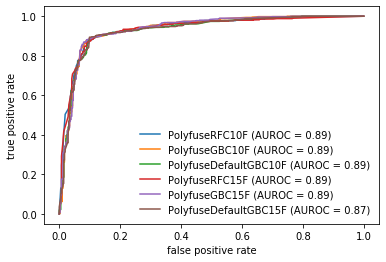

In [77]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    auroc = metrics.roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label='{} (AUROC = {:0.2f})'.format(caller, auroc))

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(frameon=False)

PolyfuseRFC4F
PolyfuseGBC4F
PolyfuseDefaultGBC4F
PolyfuseRFC7F
PolyfuseGBC7F
PolyfuseDefaultGBC7F


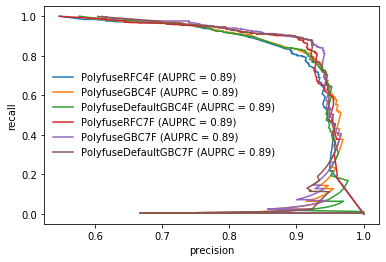

In [27]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_prob)
    auprc = auc(recall, precision)
    plt.plot(precision, recall, label='{} (AUPRC = {:0.2f})'.format(caller, auroc))

plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(frameon=False)
# looks funky, but see: https://stats.stackexchange.com/questions/183504/are-precision-and-recall-supposed-to-be-monotonic-to-classification-threshold

In [21]:
from sklearn.feature_selection import RFECV
#classifier = joblib.load(os.path.join(out_dir, 'models/GBC22F.joblib'))
start = time.time()
classifier = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=1250, subsample=1.)
classifier.fit(x_train, y_train)


cv_selector = RFECV(classifier, cv=5, step=1, scoring='recall', n_jobs=-1)
cv_selector = cv_selector.fit(x_train, y_train)
                         
rfecv_features = [feature for support, feature in zip(cv_selector.get_support(), x_train.columns) if support]
print('Optimal number of features:', cv_selector.n_features_)
print('Best features:', rfecv_features)


Optimal number of features: 19
Best features: ['starseqr_called', 'starseqr_spanning_reads', 'starseqr_junction_reads', 'starfusion_spanning_reads', 'starfusion_junction_reads', 'arriba_spanning_reads', 'fusioncatcher_called', 'fusioncatcher_spanning_reads', 'fusioncatcher_junction_reads', 'pizzly_called', 'pizzly_spanning_reads', 'pizzly_junction_reads', 'mapsplice2_spanning_reads', 'mapsplice2_junction_reads', 'FFPM', 'RightBreakEntropy', 'coverage1', 'coverage2', 'arriba_confidence_low']


NameError: name 'cv_estimator' is not defined

<Figure size 576x576 with 0 Axes>

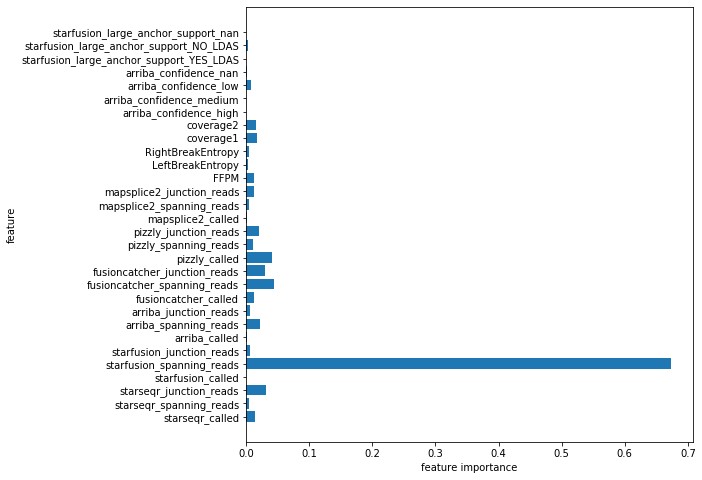

calculated best features in 3502.6s


In [22]:
n_features = x_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), classifier.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), x_train.columns.values) 
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.show()
print('calculated best features in {:.1f}s'.format(time.time() - start))

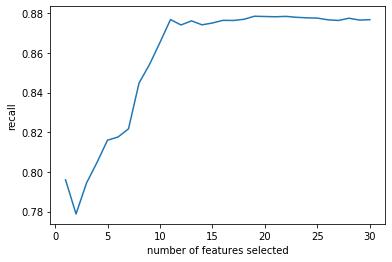

In [60]:
plt.figure()
plt.xlabel("number of features selected")
plt.ylabel("recall")
plt.plot(range(1, len(cv_selector.grid_scores_) + 1), cv_selector.grid_scores_)
plt.show()

In [ ]:
start = time.time()
cv_selector = RFECV(classifier, cv=5, step=1, scoring='accuracy', n_jobs=-1)
cv_selector = cv_selector.fit(x_train, y_train)
                         
rfecv_features = [feature for support, feature in zip(cv_selector.get_support(), x_train.columns) if support]
print('Optimal number of features:', cv_selector.n_features_)
print('Best features:', rfecv_features)
n_features = x_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), cv_estimator.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), x_train.columns.values) 
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.show()
print('calculated best features in {:.1f}s'.format(time.time() - start))

In [52]:
x_train

,FFPM,LargeAnchorSupport,LeftBreakEntropy,RightBreakEntropy,arriba_called,arriba_confidence_high,arriba_confidence_low,arriba_confidence_medium,arriba_confidence_nan,arriba_junction_reads,arriba_spanning_reads,confidence,coverage1,coverage2,fusioncatcher_called,fusioncatcher_junction_reads,fusioncatcher_spanning_reads,mapsplice2_called,mapsplice2_junction_reads,mapsplice2_spanning_reads,pizzly_called,pizzly_junction_reads,pizzly_spanning_reads,starfusion_called,starfusion_junction_reads,starfusion_large_anchor_support_NO_LDAS,starfusion_large_anchor_support_YES_LDAS,starfusion_large_anchor_support_nan,starfusion_spanning_reads,starseqr_called,starseqr_junction_reads,starseqr_spanning_reads
0,0.800,NaN,1.690,1.832,1,1.0,0.0,0.0,0.0,6.0,19.0,NaN,51.0,27.0,1,5.0,19.0,1,7.0,22.0,1,13.0,2.0,1,5.0,0.0,1.0,0.0,19.0,1,6.0,19.0
1,0.000,NaN,0.000,0.000,1,1.0,0.0,0.0,0.0,6.0,47.0,NaN,181.0,34.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
2,21.900,NaN,1.933,1.933,1,1.0,0.0,0.0,0.0,126.0,300.0,NaN,2038.0,655.0,1,25.0,457.0,1,304.0,778.0,1,407.0,130.0,1,153.0,0.0,1.0,0.0,504.0,1,137.0,429.0
3,5.000,NaN,1.966,1.889,1,1.0,0.0,0.0,0.0,23.0,113.0,NaN,129.0,113.0,1,19.0,114.0,1,38.0,210.0,1,104.0,28.0,1,24.0,0.0,1.0,0.0,126.0,1,22.0,125.0
4,90.833,NaN,1.922,1.829,1,1.0,0.0,0.0,0.0,420.0,300.0,NaN,1534.0,1530.0,1,25.0,2040.0,1,1086.0,3248.0,1,1777.0,472.0,1,647.0,0.0,1.0,0.0,2078.0,1,425.0,1900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,0.000,NaN,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,1,19.0,81.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1008,0.000,NaN,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,714.0,241.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1009,0.000,NaN,0.000,0.000,1,1.0,0.0,0.0,0.0,8.0,26.0,NaN,92.0,33.0,0,0.0,0.0,0,0.0,0.0,1,24.0,10.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1010,0.000,NaN,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,136.0,37.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0


In [54]:
x_train.fillna(0)

,FFPM,LargeAnchorSupport,LeftBreakEntropy,RightBreakEntropy,arriba_called,arriba_confidence_high,arriba_confidence_low,arriba_confidence_medium,arriba_confidence_nan,arriba_junction_reads,arriba_spanning_reads,confidence,coverage1,coverage2,fusioncatcher_called,fusioncatcher_junction_reads,fusioncatcher_spanning_reads,mapsplice2_called,mapsplice2_junction_reads,mapsplice2_spanning_reads,pizzly_called,pizzly_junction_reads,pizzly_spanning_reads,starfusion_called,starfusion_junction_reads,starfusion_large_anchor_support_NO_LDAS,starfusion_large_anchor_support_YES_LDAS,starfusion_large_anchor_support_nan,starfusion_spanning_reads,starseqr_called,starseqr_junction_reads,starseqr_spanning_reads
0,0.800,0,1.690,1.832,1,1.0,0.0,0.0,0.0,6.0,19.0,0,51.0,27.0,1,5.0,19.0,1,7.0,22.0,1,13.0,2.0,1,5.0,0.0,1.0,0.0,19.0,1,6.0,19.0
1,0.000,0,0.000,0.000,1,1.0,0.0,0.0,0.0,6.0,47.0,0,181.0,34.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
2,21.900,0,1.933,1.933,1,1.0,0.0,0.0,0.0,126.0,300.0,0,2038.0,655.0,1,25.0,457.0,1,304.0,778.0,1,407.0,130.0,1,153.0,0.0,1.0,0.0,504.0,1,137.0,429.0
3,5.000,0,1.966,1.889,1,1.0,0.0,0.0,0.0,23.0,113.0,0,129.0,113.0,1,19.0,114.0,1,38.0,210.0,1,104.0,28.0,1,24.0,0.0,1.0,0.0,126.0,1,22.0,125.0
4,90.833,0,1.922,1.829,1,1.0,0.0,0.0,0.0,420.0,300.0,0,1534.0,1530.0,1,25.0,2040.0,1,1086.0,3248.0,1,1777.0,472.0,1,647.0,0.0,1.0,0.0,2078.0,1,425.0,1900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,0.000,0,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,1,19.0,81.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1008,0.000,0,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,714.0,241.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1009,0.000,0,0.000,0.000,1,1.0,0.0,0.0,0.0,8.0,26.0,0,92.0,33.0,0,0.0,0.0,0,0.0,0.0,1,24.0,10.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1010,0.000,0,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,136.0,37.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
